Import the required libraries

In [163]:
import cv2
import os
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from skimage.feature import hog

In [164]:
ImagePath = 'Data/DataSet.csv'
ImageNames = pd.read_csv(ImagePath, header=0, index_col=False)
#ImageNames['file'] = ImageNames['file'].apply(lambda x: 'DataSets/files/1/'+x )

In [165]:
print(ImageNames.head())

               file  people
0  Data/1/1_231.png       3
1  Data/1/1_232.png       1
2  Data/1/1_233.png       2
3  Data/1/1_234.png       2
4  Data/1/1_235.png       1


In [166]:
ImageNames['people'].unique()

array([3, 1, 2, 4, 5, 0, 6])

(256, 256)


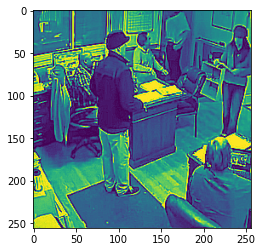

In [167]:
img = cv2.imread(ImageNames.iloc[100].tolist()[0], cv2.IMREAD_GRAYSCALE)
print(img.shape)
#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gray)
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img2 = cv2.filter2D(img, -1, kernel)
plt.imshow(img2)

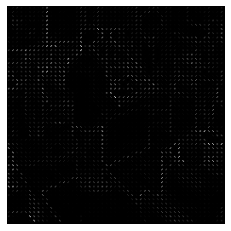

In [168]:

#creating hog features
fd, hog_image1 = hog(img, orientations=16, pixels_per_cell=(5, 5),
                	cells_per_block=(4, 4), visualize=True)#, multichannel=True)
plt.axis("off")
plt.imshow(hog_image1, cmap="gray")

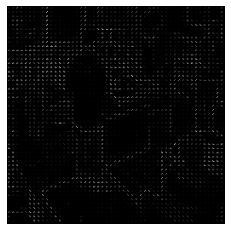

In [169]:
#creating hog2 features
fd, hog_image2 = hog(img2, orientations=9, pixels_per_cell=(5, 5),
                	cells_per_block=(10, 10), visualize=True)#, multichannel=True)
plt.axis("off")
plt.imshow(hog_image2, cmap="gray")


In [170]:
def loadData():
    imag = []
    y=[]
    imagDir = ImageNames['file'].tolist()
    ab = ImageNames['people'].tolist()
    a = 0
    for i in imagDir:
        try:
            img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
            #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            #img2 = cv2.filter2D(img, -1, kernel)
            img1 = cv2.resize(img, (256, 256))
            _, hog_image = hog(img1, orientations=16, pixels_per_cell=(5, 5),
                    cells_per_block=(4, 4), visualize=True)#, multichannel=True)
            new = hog_image.flatten() #hog_image.flatten()
            mag = np.array(new, dtype='float32')
            imag.append(mag)
            y.append(ab[a])
            a +=1 
        except Exception as E:
            print(E,i)
    #print(imag)
    return imag,y
        

In [171]:
X,y = loadData()
print('Length of X:', len(X), 'y: ', len(y))
#y = ImageNames['people'].tolist()

Length of X: 340 y:  340


In [172]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # decision tee algorithm for classification
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score 
import pickle

In [173]:
def get_stacking():
	# define the base models: level0 models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model: level 1
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

In [174]:
rf = RandomForestClassifier(n_estimators=80, criterion='entropy')

def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['bayes'] = GaussianNB()
	models['svm_Linear'] = SVC(kernel='linear')
	models['svm_Polly'] = SVC(kernel='poly')
	models['svm_RBF'] = SVC(kernel='rbf')
	models['svm_Sigmoid'] = SVC(kernel='sigmoid')
	#models['Decision_Tree'] = DecisionTreeClassifier()
	models['dt_ent'] = DecisionTreeClassifier(criterion='entropy')
	models['dt_gini'] = DecisionTreeClassifier(criterion='gini')
	models['rf'] = RandomForestClassifier(n_estimators=80, criterion='entropy')
	models['adaboost'] = AdaBoostClassifier(base_estimator=rf, n_estimators=2)
	models['stacking'] = get_stacking()
	return models

In [175]:
import numpy as np

def evaluate_model_Multi(model, X, y):
  mc=10
  acc = [] ### Blank vector
  for i in range(mc):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=i)# split dataset
    dt = model.fit(X_train,y_train) # fit the model
    YPred = dt.predict(X_test) # predict
    a = accuracy_score(y_test,YPred) # compute accuracy
    acc.append(a) # append accuracy
    return np.mean(acc), dt

In [176]:
def evaluate_model_cross(model, X, y, name):
	cv = 8
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
	return scores

In [206]:
from numpy import mean, std
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores, mod = evaluate_model_Multi(model, X, y)
	results.append(scores)
	names.append(name)
	filename = 'Models/'+name+'.pkl'
	pickle.dump(mod, open(filename, 'wb'))
	print((name, mean(scores),std(scores)))

('lr', 0.696078431372549, 0.0)
('bayes', 0.4019607843137255, 0.0)
('svm_Linear', 0.6764705882352942, 0.0)
('svm_Polly', 0.7254901960784313, 0.0)
('svm_RBF', 0.7254901960784313, 0.0)
('svm_Sigmoid', 0.7156862745098039, 0.0)
('dt_ent', 0.5490196078431373, 0.0)
('dt_gini', 0.5098039215686274, 0.0)
('rf', 0.7254901960784313, 0.0)
('adaboost', 0.7254901960784313, 0.0)
('stacking', 0.7058823529411765, 0.0)


In [123]:
# get the models to evaluate
import warnings
warnings.filterwarnings("ignore")
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model_cross(model, X, y, name)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.529 (0.042)
>bayes 0.447 (0.072)
>svm_Linear 0.559 (0.044)
>svm_Polly 0.571 (0.049)
>svm_RBF 0.665 (0.006)
>svm_Sigmoid 0.665 (0.006)
>dt_ent 0.526 (0.041)
>dt_gini 0.456 (0.074)
>rf 0.679 (0.029)
>adaboost 0.682 (0.032)
>stacking 0.662 (0.016)


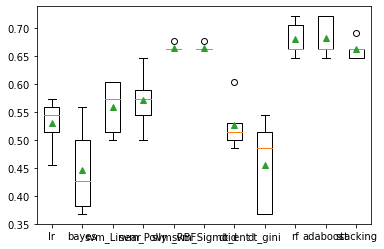

In [126]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Checking Different Test size for Ada boost Classifier 

In [124]:
import numpy as np

tsize = [0.2,0.3,0.4,0.5,0.6,0.7]
tsize_acc = {}
for i in tsize:
    acc = []
    for j in range(50):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=i, random_state = j)
        ab= AdaBoostClassifier(base_estimator=rf, n_estimators=2)
        ab.fit(X_train, y_train)
        dt_pred = ab.predict(X_test)
        accuracy = accuracy_score(y_test,dt_pred)
        acc.append(accuracy)
    tsize_acc.update({i:np.mean(acc)})
print(tsize_acc)

{0.2: 0.6994117647058823, 0.3: 0.6901960784313727, 0.4: 0.6816176470588234, 0.5: 0.6728235294117648, 0.6: 0.6702941176470587, 0.7: 0.6653781512605041}


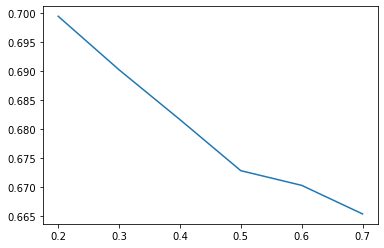

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(*zip(*sorted(tsize_acc.items())))
plt.show()

Checking Number of estimators for Random Forest Classifier 

In [133]:
num_est = np.arange(10,100,10)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    rf = RandomForestClassifier(n_estimators = n_est, criterion='entropy')
    scores = cross_val_score(rf, X, y, cv=8, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

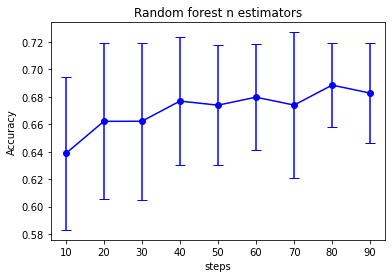

In [134]:
plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('Random forest n estimators');
plt.show()

Checking different K-Fold for Random Forest Classifier 

In [129]:
num_est = np.arange(2,40,4)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    rf = RandomForestClassifier(n_estimators = 70, criterion='entropy')
    scores = cross_val_score(rf, X, y, cv=n_est, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

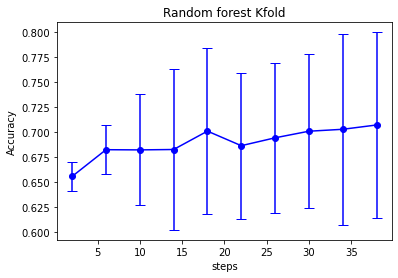

In [130]:
plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('Random forest Kfold');
plt.show()

Checking Number of estimaters for Ada Boost Classifier 

In [75]:
from sklearn.ensemble import AdaBoostClassifier

rf = RandomForestClassifier(n_estimators=80, criterion='entropy')

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

In [76]:
num_est = np.arange(2,20,2)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=rf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

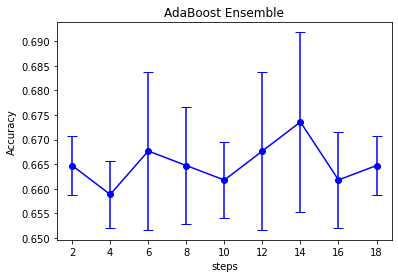

In [77]:
plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('AdaBoost Ensemble');
plt.show()

Bagging Approch

In [ ]:
"""
import warnings
warnings.filterwarnings("ignore")

clf1 = GaussianNB()    # base learner 2
clf2 = DecisionTreeClassifier(criterion='entropy')# base learner 1
# bagging learner 1
rand1 = RandomForestClassifier(n_estimators=60, criterion='entropy')
bagging1 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)
# bagging learner 2
bagging2 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)

label = ['Decision Tree', 'LR', 'Bagging Tree', 'Bagging LR']
clf_list = [clf1, clf2, bagging1, bagging2]
 

for clf, label  in zip(clf_list, label ):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print ("Accuracy:  ",(round(scores.mean(),4), round(scores.std(),3), label))


num_est = np.arange(10,100,10)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for i in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=i, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
#bg_clf_cv_mean

plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()
"""

Testing With new data set

In [252]:
def testData(ImageNames):
    imag = []
    y=[]
    imagDir = ImageNames['file'].tolist()
    ab = ImageNames['people'].tolist()
    a = 0
    for i in imagDir:
        img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #img2 = cv2.filter2D(img, -1, kernel)
        img1 = cv2.resize(img, (256, 256))
        _, hog_image = hog(img1, orientations=16, pixels_per_cell=(5, 5),
                    cells_per_block=(4, 4), visualize=True)#, multichannel=True)
        new = hog_image.flatten() #hog_image.flatten()
        mag = np.array(new, dtype='float32')
        imag.append(mag)
        y.append(ab[a])
        a +=1 
    return imag,y

def Feat(FileName):
    img = cv2.imread(FileName, cv2.IMREAD_GRAYSCALE)
    #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #img2 = cv2.filter2D(img, -1, kernel)
    img1 = cv2.resize(img, (256, 256))
    _, hog_image = hog(img1, orientations=16, pixels_per_cell=(5, 5),
                    cells_per_block=(4, 4), visualize=True)#, multichannel=True)
    new = hog_image.flatten() #hog_image.flatten()
    mag = np.array(new, dtype='float32')
    return [mag], hog_image,img1

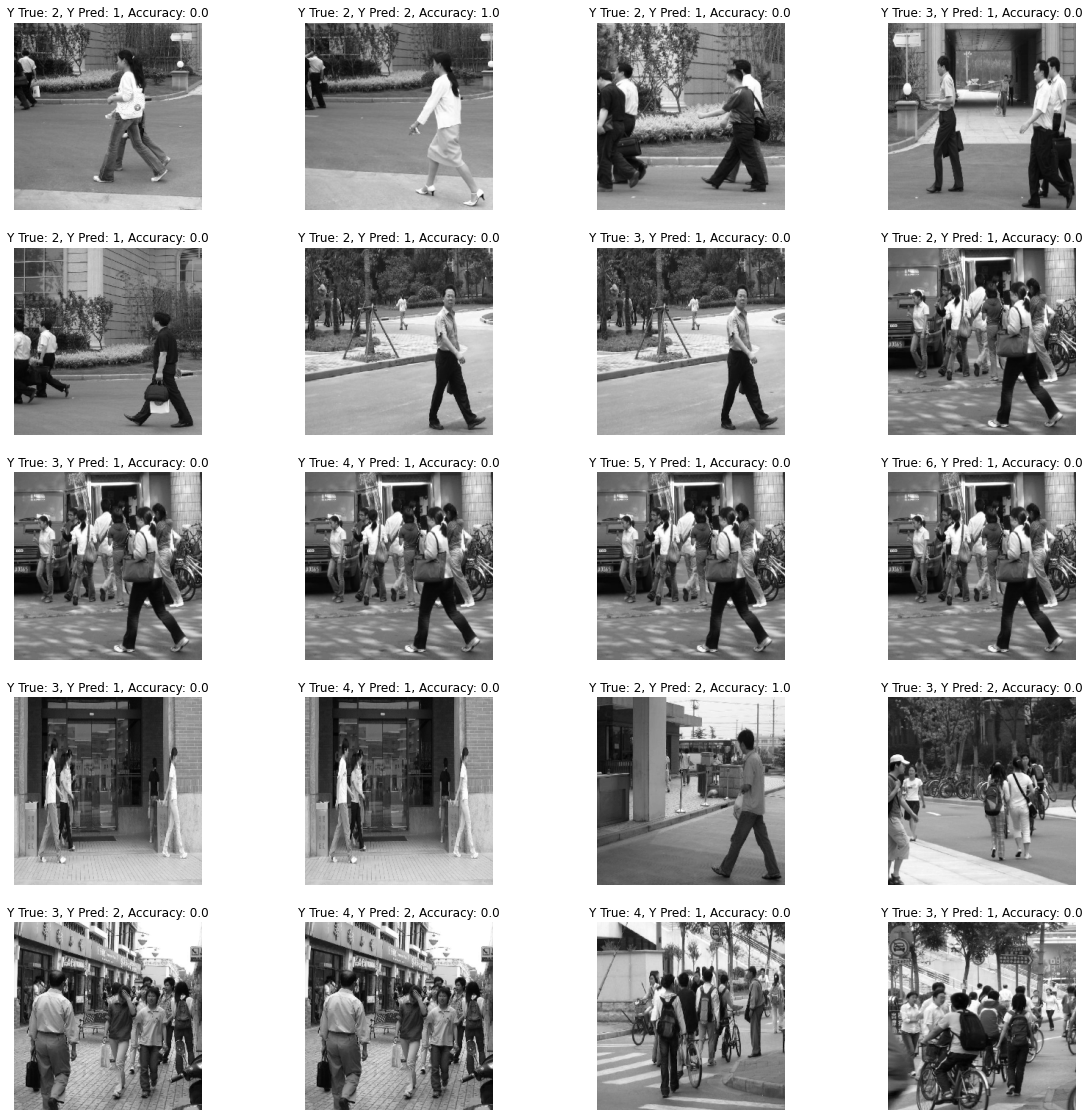

In [266]:
ImagePath = 'Data/testdb.csv'
TestImage = pd.read_csv(ImagePath, header=0, index_col=False)
model_name = 'Models/lr.pkl'

# load the model from disk
#X_test, y_test = testData(TestImage)
plt.figure(figsize=(20,20))
b = 10
for i in range(20):
    #creating hog features
    a = []
    X_test, hog_img, img = Feat(TestImage.iloc[i].tolist()[0])
    y_test = [TestImage.iloc[i].tolist()[1]]

    loaded_model = pickle.load(open(model_name, 'rb'))
    #result = loaded_model.score(X_test, y_pred)
    y_pred = loaded_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) # compute accuracy
    plt.subplot(5,4,i+1)
    plt.imshow(img, cmap="gray")
    plt.title('Y True: '+str(y_test[0])+', '+'Y Pred: '+str(y_pred[0]) +', '+'Accuracy: '+str(acc))
    plt.axis('off')
    #print('y actual: ',y_test,'Y Predicted: ',y_pred )
    #print('Accuracy Score: ',acc)
    #print(str(y_test[0]))
    #print(str(y_pred[0]))
    

